# Running Haystack Pipelines in Asynchronous Environments

_Notebook by [Madeeswaran Kannan](https://www.linkedin.com/in/m-kannan) & [Mathis Lucka](https://www.linkedin.com/in/mathis-lucka-685037201/)_

In this notebook, you'll learn how to use the `AsyncPipeline` and async-enabled components to build and execute a Haystack pipeline in an asynchronous environment. It's based on [this short Haystack tutorial](https://haystack.deepset.ai/tutorials/27_first_rag_pipeline), so it would be a good idea to familiarize yourself with it before we begin. A further prerequisite is working knowledge of cooperative scheduling and [async programming in Python](https://docs.python.org/3/library/asyncio.html).

## Motivation

By default, the `Pipeline` class in `haystack` is a regular Python object class that exposes non-`async` methods to add/connect components and execute the pipeline logic. Currently, it *can* be used in async environments, but it's not optimal to do so since it executes its logic in a '[blocking](https://en.wikipedia.org/wiki/Blocking_(computing))' fashion, i.e., once the `Pipeline.run` method is invoked, it must run to completion and return the outputs before the next statement of code can be executed<sup>1</sup>. In a typical async environment, this prevents active async event loop from scheduling other `async` coroutines, thereby reducing throughput. To mitigate this bottleneck, we introduce the concept of async-enabled Haystack components and an `AsyncPipeline` class that cooperatively schedules the execution of both async and non-async components.


<sup>1</sup> - This is a simplification as the Python runtime can potentially schedule another thread, but it's a detail that we can ignore in this case.

### AsyncPipeline Benefits
- Execute components concurrently to speed-up pipeline execution.
- Execute components step by step to debug your pipelines.
- Increase throughput in async environments, e.g. when executing pipelines behind a FastAPI-endpoint.
- Allow individual components to opt into `async` support.
    - Not all components benefit from being async-enabled - I/O-bound components are the most suitable candidates.
- Provide a backward-compatible way to execute Haystack pipelines containing both async and non-async components.


Let's now go ahead and see what it takes to add async support to the original tutorial, starting with installing Haystack, and the requisite dependencies.

## Development Environment


In [ ]:
%%bash

pip install -U haystack-ai -q
pip install datasets -q
pip install sentence-transformers -q
pip install nest_asyncio -q

Provide an [OpenAI API key](https://platform.openai.com/api-keys) to ensure that LLM generator can query the OpenAI API.

In [ ]:
import os
from getpass import getpass

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key:")

# If you're running this notebook on Google Colab, you can do the following instead:
#
# from google.colab import userdata
# if "OPENAI_API_KEY" not in os.environ:
#  os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

In [29]:
# The IPython environment is already running an event-loop.
# We will later use a method that tries to create another event-loop which would fail without this snippet.
import nest_asyncio
nest_asyncio.apply()

## Creating an AsyncPipeline

### Fetching and Indexing Documents
Initialize a `DocumentStore` to index your documents.

In [30]:
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()

Fetch the data and convert it into Haystack `Document`s.

In [31]:
from datasets import load_dataset
from haystack import Document

dataset = load_dataset("bilgeyucel/seven-wonders", split="train")
docs = [Document(content=doc["content"], meta=doc["meta"]) for doc in dataset]

To store your data in the `DocumentStore` with embeddings, initialize a `SentenceTransformersDocumentEmbedder` with the model name and call `warm_up()` to download the embedding model.

Then, we calculate the embeddings of the docs with the newly warmed-up embedder and write the documents to the document store.

In [32]:
from haystack.components.embedders import SentenceTransformersDocumentEmbedder

doc_embedder = SentenceTransformersDocumentEmbedder(
    model="sentence-transformers/all-MiniLM-L6-v2"
)
doc_embedder.warm_up()

docs_with_embeddings = doc_embedder.run(docs)
n_docs_written = document_store.write_documents(docs_with_embeddings["documents"])
print(f"Indexed {n_docs_written} documents")

Batches: 100%|██████████| 5/5 [00:00<00:00,  5.37it/s]

Indexed 151 documents


The next step is to build the RAG pipeline to generate answers for a user query. We build a RAG pipeline using hybrid retrieval. Hybrid retrieval uses to retrieval branches that can run concurrently.

Initialize a text embedder to create an embedding for the user query and an `InMemoryEmbeddingRetriever` as well as a `InMemoryBM25Retriever` to use with the `InMemoryDocumentStore` you initialized earlier. We feed the results of both retrievers into a `DocumentJoiner` and we use reciprocal rank fusion to get to our final ranking of the documents.

In [22]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever, InMemoryBM25Retriever
from haystack.components.joiners import DocumentJoiner

text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
embedding_retriever = InMemoryEmbeddingRetriever(document_store)
bm25_retriever = InMemoryBM25Retriever(document_store)
joiner = DocumentJoiner(join_mode="reciprocal_rank_fusion")


Create a custom prompt to use with the `ChatPromptBuilder` and initialize a `OpenAIChatGenerator` to consume the output of the former.

In [23]:
from haystack.components.builders import ChatPromptBuilder
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.dataclasses import ChatMessage

template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

prompt_builder = ChatPromptBuilder(template=[ChatMessage.from_user(template)])
generator = OpenAIChatGenerator(model="gpt-4o-mini")

We finally get to the creation of the pipeline instance. Instead of using the `Pipeline` class, we use the `AsyncPipeline` class.

The rest of the process, i.e., adding components and connecting them with each other remains the same as with the original `Pipeline` class.

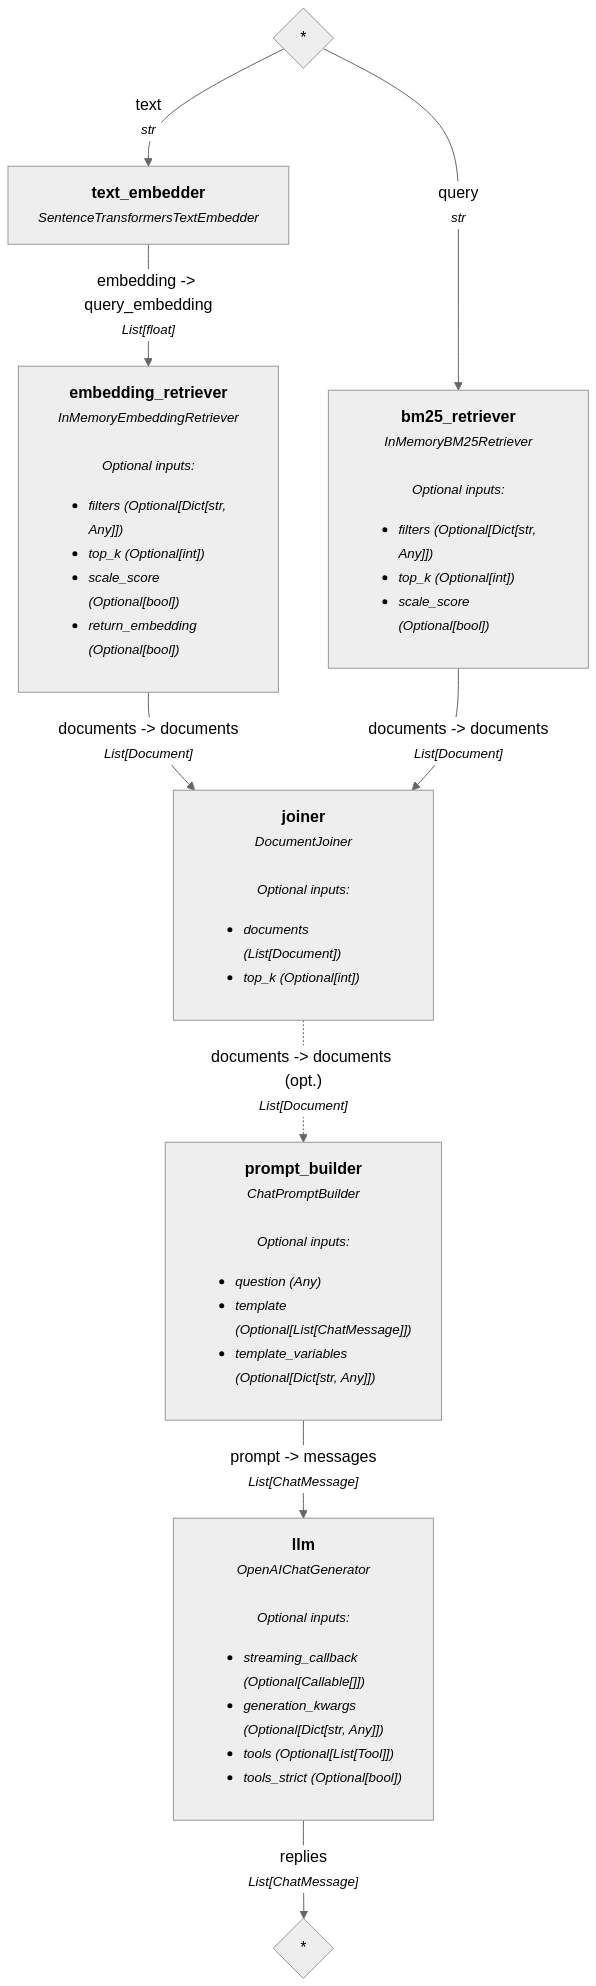

In [24]:
from haystack import AsyncPipeline

async_rag_pipeline = AsyncPipeline()
# Add components to your pipeline
async_rag_pipeline.add_component("text_embedder", text_embedder)
async_rag_pipeline.add_component("embedding_retriever", embedding_retriever)
async_rag_pipeline.add_component("bm25_retriever", bm25_retriever)
async_rag_pipeline.add_component("joiner", joiner)
async_rag_pipeline.add_component("prompt_builder", prompt_builder)
async_rag_pipeline.add_component("llm", generator)

# Now, connect the components to each other
async_rag_pipeline.connect("text_embedder.embedding", "embedding_retriever.query_embedding")
async_rag_pipeline.connect("bm25_retriever.documents", "joiner.documents")
async_rag_pipeline.connect("embedding_retriever.documents", "joiner.documents")
async_rag_pipeline.connect("joiner.documents", "prompt_builder.documents")
async_rag_pipeline.connect("prompt_builder.prompt", "llm.messages")

async_rag_pipeline.show()
# You can see from the visual pipeline representation that embedding retriever and bm25 retriever do not depend on each other; they could run concurrently

Now, we create a coroutine that queries the pipeline with a question.

We use the `run_async_generator` method to execute the `AsyncPipeline`. `run_async_generator` returns an `AsyncIterator` that we need to iterate over to make progress in the pipeline's execution.

Essentially, this allows us to step through the pipeline execution component by component, which is useful for debugging a pipeline or when you want to run custom logic upon any component's completion.

The `AsyncPipeline` also exposes:
 
- a `run_async` method that executes the full pipeline before returning the final outputs
- a `run` method that can be called from non-async environments but still executes components concurrently; the `run` method is a drop-in replacement for `Pipeline.run`


We iterate over the `AsyncIterator` and print intermediate outputs from the retrievers and the joiner.


In [11]:
question = "Where is Gardens of Babylon?"
inputs = {
    "text_embedder": {"text": question},
    "bm25_retriever": {"query": question},
    "prompt_builder": {"question": question},
}
include_outputs_from = ["embedding_retriever", "bm25_retriever", "joiner"]
consumed_outputs = []
async for output in async_rag_pipeline.run_async_generator(data=inputs, include_outputs_from=include_outputs_from):
    final_output = output
    for component, results in output.items():
        if component not in consumed_outputs:
            consumed_outputs.append(component)
            if "documents" in results:
                print(f"Outputs from `{component}`.")
                for doc in results["documents"][:1]:
                    print(f"Score: {doc.score}")
                    print(f"Content: {doc.content[:500]}...")
                    print("------------")


print("LLM Response:")
print(final_output["llm"]["replies"][0].text)
    

Outputs from `bm25_retriever`.
Score: 13.520340633994273
Content: [21] However, the gardens were said to still exist at the time that later writers described them, and some of these accounts are regarded as deriving from people who had visited Babylon.[2] Herodotus, who describes Babylon in his Histories, does not mention the Hanging Gardens,[22] although it could be that the gardens were not yet well known to the Greeks at the time of his visit.[2]
To date, no archaeological evidence has been found at Babylon for the Hanging Gardens.[6] It is possible that ev...
------------
Outputs from `embedding_retriever`.
Score: 0.6933103186685945
Content: The construction of the Hanging Gardens has also been attributed to the legendary queen Semiramis[4] and they have been called the Hanging Gardens of Semiramis as an alternative name.[5]
The Hanging Gardens are the only one of the Seven Wonders for which the location has not been definitively established.[6] There are no extant Babylonian texts

## Sequential vs Concurrent Execution
Now, let's compare sequential execution and concurrent execution of multiple queries. We create two utility functions that run a list of questions. Both use the `AsyncPipeline` but only one of them runs each question as a co-routine.

In [25]:
import asyncio

def sequential_execution(pipeline: AsyncPipeline, questions: list[str]):
    results = []
    for question in examples:
        inputs = {
            "text_embedder": {"text": question},
            "bm25_retriever": {"query": question},
            "prompt_builder": {"question": question},
        }
        
        results.append(pipeline.run(data=inputs))
    
    return results

async def concurrent_execution(pipeline: AsyncPipeline, questions: list[str]):
    tasks = [pipeline.run_async(data={
        "text_embedder": {"text": question},
        "bm25_retriever": {"query": question},
        "prompt_builder": {"question": question},
    }) for question in questions]
    
    results = await asyncio.gather(*tasks)
    
    return results


We run the pipeline with 3 examples.

In [26]:
examples = [
    "Where is Gardens of Babylon?",
    "Why did people build Great Pyramid of Giza?",
    "What does Rhodes Statue look like?",
]

Let's run the questions sequentially first.

In [27]:
import time

start = time.time()
results = sequential_execution(async_rag_pipeline, examples)
end = time.time()
total_time = end - start
print(f"All tasks completed in {total_time:.2f} seconds")

All tasks completed in 8.48 seconds


Let's check how long it takes if we run questions concurrently.

In [28]:
start = time.time()
results = await concurrent_execution(async_rag_pipeline, examples)
end = time.time()
total_time = end - start
print(f"All tasks completed in {total_time:.2f} seconds")



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


All tasks completed in 3.57 seconds


You can see that concurrent execution of the pipeline is more than twice as fast as the sequential execution.

## Concurrent Component Execution

The example above is running the retriever components concurrently. Any components that could run concurrently, typically because they sit on parallel branches of the pipeline, are automatically scheduled to run concurrently by the `AsyncPipeline`'s run-logic.

Let's create a small example with a custom component to illustrate concurrent execution in more detail.

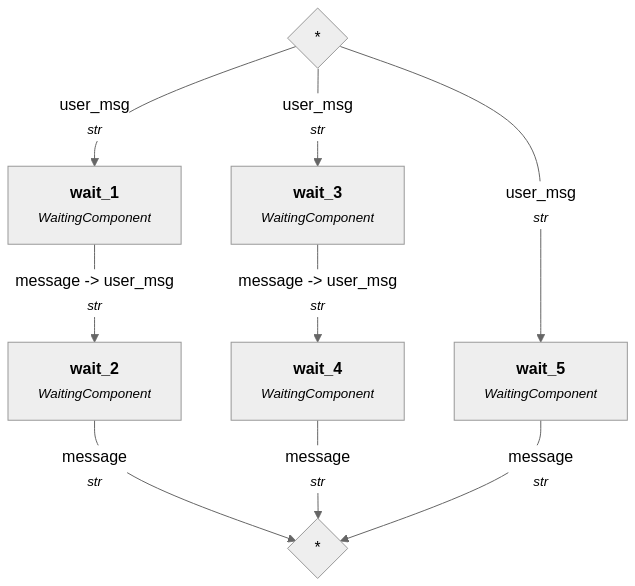

In [45]:
from haystack import component

@component
class WaitingComponent:
    """
    A test component that simulates async operations by waiting for a specified time
    before returning a message.

    ### Usage example
    ```python
    test_comp = AsyncTestComponent(name="TestComponent", wait_time=2)

    # Sync usage
    result = test_comp.run(user_msg="Hello")
    print(result["message"])  # prints after 2 seconds

    # Async usage
    result = await test_comp.run_async(user_msg="Hello")
    print(result["message"])  # prints after 2 seconds
    ```
    """

    def __init__(self, name: str, wait_time: int = 1):
        self.name = name
        self.wait_time = wait_time

    @component.output_types(message=str)
    def run(self, user_msg: str) -> dict:
        """
        Synchronous method that waits for the specified time and returns a message.

        :param user_msg: Input message from the user (unused in output but required for example)
        :return: Dictionary containing the output message
        """
        print(f"Component {self.name} starts running...")
        time.sleep(self.wait_time)
        print(f"Component {self.name} is done!")
        return {"message": f"Message from {self.name}"}


wait_1 = WaitingComponent(name="wait_1", wait_time=1)
wait_2 = WaitingComponent(name="wait_2", wait_time=2)
wait_3 = WaitingComponent(name="wait_3", wait_time=3)
wait_4 = WaitingComponent(name="wait_4", wait_time=4)
wait_5 = WaitingComponent(name="wait_5", wait_time=5)

pp = AsyncPipeline()


pp.add_component("wait_1", wait_1)
pp.add_component("wait_2", wait_2)
pp.add_component("wait_3", wait_3)
pp.add_component("wait_4", wait_4)
pp.add_component("wait_5", wait_5)

pp.connect("wait_1", "wait_2")
pp.connect("wait_3", "wait_4")

pp.show()

You can see that this pipeline has 3 parallel branches. Let's run this pipeline to see how it executes components concurrently.

In [46]:
async for output in pp.run_async_generator({"user_msg": "Hello"}, include_outputs_from=["wait_1", "wait_2", "wait_3", "wait_4", "wait_10"]):
    if len(output.keys()) == 1:
        print(output)

{'wait_1': {'message': 'Message from wait_1'}}
{'wait_3': {'message': 'Message from wait_3'}}
{'wait_2': {'message': 'Message from wait_2'}}
{'wait_5': {'message': 'Message from wait_5'}}
{'wait_4': {'message': 'Message from wait_4'}}


## Custom Asynchronous Components

Individual components can opt into async by implementing a `run_async` coroutine that has the same signature, i.e., input parameters and outputs as the `run` method. This constraint is placed to ensure that pipeline connections are the same irrespective of whether a component supports async execution, allowing for plug-n-play backward compatibility with existing pipelines.


In [ ]:
from typing import Dict, Any
from haystack import component

@component
class MyCustomComponent:
    def __init__(self, my_custom_param: str):
        self.my_custom_param = my_custom_param

    @component.output_types(original=str, concatenated=str)
    def run(self, input: str) -> Dict[str, Any]:
        return {
            "original": input,
            "concatenated": input + self.my_custom_param
        }

    async def do_io_bound_op(self, input: str) -> str:
        # Do some IO-bound operation here
        return input + self.my_custom_param

    @component.output_types(original=str, concatenated=str)
    async def run_async(self, input: str) -> Dict[str, Any]:
        return {
            "original": input,
            "concatenated": await self.do_io_bound_op(input)
        }